In [1]:

import hist
import dask
import awkward as ak
import hist.dask as hda
import dask_awkward as dak
import numpy as np

from coffea import processor
from coffea.nanoevents.methods import candidate
from coffea.nanoevents.methods import vector as vec
from coffea.dataset_tools import (
    apply_to_fileset,
    max_chunks,
    preprocess,
)

def match_b_to_a(a_obj, b_obj, match_dr):
    '''this function will find the match the closest b to a 
        match_dr is a rough cut, it set a limit; in case i got the clossest, but they are already far enough to consider to be different things'''
    a = ak.zip(
        {"pt": ak.fill_none(a_obj.pt, 0.0),
         "eta": ak.fill_none(a_obj.eta, 0.0),
         "phi": ak.fill_none(a_obj.phi, 0.0),
         "mass": ak.fill_none(getattr(a_obj, "mass", ak.zeros_like(a_obj.pt)), 0.0)},
        with_name="PtEtaPhiMCandidate", behavior=candidate.behavior,
    )
    b = ak.zip(
        {"pt": ak.fill_none(b_obj.pt, 0.0),
         "eta": ak.fill_none(b_obj.eta, 0.0),
         "phi": ak.fill_none(b_obj.phi, 0.0),
         "mass": ak.fill_none(getattr(b_obj, "mass", ak.zeros_like(b_obj.pt)), 0.0)},
        with_name="PtEtaPhiMCandidate", behavior=candidate.behavior,
    )

    # Cartesian pairs per event: shape [evt, len(a_i), len(b_i)]
    pairs = ak.cartesian({"a": a, "b": b}, axis=1, nested=True)

    # delta R for every (a,b)
    dr = pairs.a.delta_r(pairs.b)
    
    
    #dr = a_obj.delta_r(b_obj)
    # get things within the match_dr, and keep the shape by leaving a default value
    default = 99999.0
    dr_incone = ak.where(dr < match_dr, dr, default) 
    # get the closest b for each a
    min_dr = ak.min(dr_incone, axis=-1, initial=default)  # note if no min is found, assign the default value. this var is to check for argmin          
    # make sure the code will work even if there are no b or all are cut out of the cone
    argmin = ak.argmin(dr_incone, axis=-1) 
    valid = (min_dr < default)              
    argmin_safe = ak.where(valid, argmin, 0)

    b_works  = b_obj[argmin_safe]                          
    a_match = a_obj[valid]                                
    b_match = b_works[valid]
    dr_match = min_dr[valid]


    #return a_out, b_out, dr_out
    return a_match, b_match, dr_match 

    

class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        pass

    def process(self, events):
        GEN_FLAGS = ["isLastCopy"]
        #GEN_FLAGS1 = ["fromHardProcess", "isLastCopy"]
        dataset = events.metadata['dataset']
        # getting gen level info for b and e
        #print("start")
        gen_part = events.GenPart
        gen_t_temp = gen_part[(gen_part.pdgId == 6)]
        gen_t = gen_t_temp[(gen_t_temp.hasFlags(GEN_FLAGS))]

        '''
        #--------------------check------------------------------
        n_child_raw   = ak.fill_none(ak.num(gen_t.children,          axis=2), 0)
        print("tops per evt (first 100):", ak.to_list(ak.num(gen_t, axis=1)[:100]))
        print("n children per top (raw)   first 100 evts:", ak.to_list(n_child_raw[:100]))
        t_children_pdg = gen_t.children.pdgId
        print("top.children pdgId (first 30 evts):")
        print(ak.to_list(t_children_pdg[:30]))
        #---------------------------------------------------------
        '''


        #print("check1")
        gen_t_child = gen_t.children
        gen_b = gen_t_child[(gen_t_child.pdgId == 5)]



        gen_w_lastcopy = gen_part[(gen_part.pdgId == 24) & (gen_part.hasFlags(GEN_FLAGS))]
        gen_w_child = gen_w_lastcopy.children
        gen_e = gen_w_child[(gen_w_child.pdgId == -11)]


        #print("check2") 
        
        #print("1")

        n_b_per_t = ak.fill_none(ak.num(gen_b,          axis=2), 0)  
        n_e_per_t = ak.fill_none(ak.num(gen_e, axis=2), 0) 
        n_top     = ak.fill_none(ak.num(gen_t,          axis=1), 0) 
        
        #-------------need to chage for different samples 
        good_b_evt = ak.fill_none(ak.any(n_b_per_t == 1, axis=1), False) 
        good_e_evt = ak.fill_none(ak.any(n_e_per_t == 1, axis=1), False)
        event_good = (n_top == 1) & good_b_evt & good_e_evt

        events_sel = events[event_good]  
        # cut from the sliced events to make sure the lists are clean:
        gen_part = events_sel.GenPart
        gen_t    = gen_part[(gen_part.pdgId == 6) & (gen_part.hasFlags(GEN_FLAGS))]
        gen_b = gen_t.children[(gen_t.children.pdgId == 5)]
        
        gen_w_lastcopy = gen_part[(gen_part.pdgId == 24) & (gen_part.hasFlags(GEN_FLAGS))]
        gen_w_child = gen_w_lastcopy.children
        gen_e = gen_w_child[(gen_w_child.pdgId == -11)] 
        
        
        e_all = events_sel.Electron
        b_jet = events_sel.Jet

        gen_e_all = ak.flatten(gen_e, axis=2)
        gen_b_all = ak.flatten(gen_b, axis=2) 
        #print("2")




        
        # get gen delta R
        gen_dR = gen_e_all.delta_r(gen_b_all)
        #print("3")

        e_gen_match, e_rec_match, dr_e = match_b_to_a(gen_e_all, e_all, match_dr=0.1)

        
        #print("4")
        b_gen_match, b_reco_match, dr_b = match_b_to_a(gen_b_all, b_jet, match_dr=0.2)
        #print("5")

        '''
        # --- sanity check ---
        nevt_evt  = dak.num(events_sel, axis=0).compute()
        nevt_e    = dak.num(gen_e_all,      axis=0).compute()
        nevt_b    = dak.num(gen_b_all,      axis=0).compute()
        nevt_jet  = dak.num(b_jet,      axis=0).compute()
        nevt_reco = dak.num(e_all,      axis=0).compute()
        print(f"[events] sel={nevt_evt}, gen_e={nevt_e}, gen_b={nevt_b}, reco_e={nevt_reco}, reco_j={nevt_jet}")
        
        
        print("events_sel (axis0):", dak.num(events_sel, axis=0).compute())
        print("gen_b     (axis0):",  dak.num(gen_b,     axis=0).compute())      
        print("gen_b_all (axis0):",  dak.num(gen_b_all, axis=0).compute())     
        
        print("n_b per event (first 10):", ak.to_list(ak.num(gen_b_all, axis=1)[:10]))
        print("next")
        print("n tops/evt:", ak.to_list(ak.num(gen_t, axis=1)[:10]))
        print("n b/evt:",        ak.to_list(ak.num(gen_b_all, axis=1)[:10]))
        
        #print("n W/evt:",    ak.to_list(ak.num(gen_w, axis=2)[:10]))  
        print("n e/evt:",        ak.to_list(ak.num(gen_e_all, axis=1)[:10]))
        
        
        print("before flattening list")
        nevt_evt  = dak.num(events_sel, axis=0).compute()
        #nevt_e    = dak.num(gen_e,      axis=0).compute()
        nevt_b    = dak.num(gen_b,      axis=0).compute()
        nevt_jet  = dak.num(b_jet,      axis=0).compute()
        nevt_reco = dak.num(e_all,      axis=0).compute()
        #print(f"[events] sel={nevt_evt}, gen_e={nevt_e}, gen_b={nevt_b}, reco_e={nevt_reco}, reco_j={nevt_jet}")
        print(f"[events] sel={nevt_evt}, gen_b={nevt_b}, reco_e={nevt_reco}, reco_j={nevt_jet}")
        #-----------------------------------------------------
        '''

        # clean up evens: keep only events with one matched e and one matched b
        n_em = ak.num(e_gen_match, axis=1)   
        n_bm = ak.num(b_gen_match, axis=1)   
        b_e_evt = (n_em == 1) & (n_bm == 1)
        matched_events = events_sel[b_e_evt]
        
        e_match_events = e_rec_match[b_e_evt]          
        b_match_events = b_reco_match[b_e_evt] 
        
        e_flat = ak.flatten(e_match_events, axis=1)   
        b_flat = ak.flatten(b_match_events, axis=1) 
        
        reco_dR = e_flat.delta_r(b_flat)   


        #events_sel: events w/ 1 gen b and 1 gen e
        #matched_events: events w/ 1 matched b and 1 matched e
        n_evt_gen1b1e            = ak.num(events_sel, axis=0)            
        n_evt_matched1b1e        = ak.num(matched_events, axis=0)
        #print(events_sel.HLT.fields)
        non_iso_e_trigger_gen1b1e_cut = events_sel.HLT.Ele115_CaloIdVT_GsfTrkIdT | events_sel.HLT.Ele50_CaloIdVT_GsfTrkIdT_PFJet165
        non_iso_e_trigger_matched1b1e_cut = matched_events.HLT.Ele115_CaloIdVT_GsfTrkIdT | matched_events.HLT.Ele50_CaloIdVT_GsfTrkIdT_PFJet165

        non_iso_e_trigger_gen1b1e = events_sel[non_iso_e_trigger_gen1b1e_cut]
        non_iso_e_trigger_matched1b1e = matched_events[non_iso_e_trigger_matched1b1e_cut]


        return {
            "e_gen_match": e_gen_match,
            "e_rec_match": e_rec_match,
            "dr_e": dr_e,
            "b_gen_match": b_gen_match,
            "b_reco_match": b_reco_match,
            "dr_b": dr_b,
            "reco_dR": reco_dR,
            "non_iso_e_trigger_gen1b1e": non_iso_e_trigger_gen1b1e,
            "non_iso_e_trigger_matched1b1e": non_iso_e_trigger_matched1b1e,
            "n_evt_gen1b1e": n_evt_gen1b1e,
            "n_evt_matched1b1e": n_evt_matched1b1e,
            # diagnostics (post-selection)
            "n_top": ak.num(gen_t, axis=1),  # [evt]
            "n_b_evt": ak.num(gen_b_all, axis=1),
            "n_e_evt": ak.num(gen_e_all, axis=1),
            "n_e_reco_sel": ak.num(e_all, axis=1),
            "n_j_reco_sel": ak.num(b_jet, axis=1),
            
    }
    
    
    def postprocess(self, accumulator):
        pass


/usr/local/lib/python3.12/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


In [2]:
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
from coffea.nanoevents import NanoAODSchema
from coffea.dataset_tools import preprocess, apply_to_fileset
import dask

paths = {
    3000: "root://cms-xrd-global.cern.ch//store/mc/RunIISummer20UL18NanoAODv9/SuuToTU_TToBLNu_MSuu-3000_TuneCP5_13TeV-madgraph-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/2550000/03AAF3DD-535A-1A4F-B8FE-6CDDB473BEE5.root",
    4000: "root://cms-xrd-global.cern.ch//store/mc/RunIISummer20UL18NanoAODv9/SuuToTU_TToBLNu_MSuu-4000_TuneCP5_13TeV-madgraph-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/2550000/75091ED2-34C4-A641-961A-22EBFEBEAA2F.root",
    5000: "root://cms-xrd-global.cern.ch//store/mc/RunIISummer20UL18NanoAODv9/SuuToTU_TToBLNu_MSuu-5000_TuneCP5_13TeV-madgraph-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/2550000/2CEF3CEA-9AE3-314D-9E3B-F5408416F693.root",
    6000: "root://cms-xrd-global.cern.ch//store/mc/RunIISummer20UL18NanoAODv9/SuuToTU_TToBLNu_MSuu-6000_TuneCP5_13TeV-madgraph-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/2550000/30275C47-1BBE-0E41-B00E-0CB75F8D490F.root",
    7000: "root://cms-xrd-global.cern.ch//store/mc/RunIISummer20UL18NanoAODv9/SuuToTU_TToBLNu_MSuu-7000_TuneCP5_13TeV-madgraph-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/2550000/ED2B500A-CBCD-1248-A32E-E2C60F1373B1.root",
    8000: "root://cms-xrd-global.cern.ch//store/mc/RunIISummer20UL18NanoAODv9/SuuToTU_TToBLNu_MSuu-8000_TuneCP5_13TeV-madgraph-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/2550000/3DC00E87-FCD2-5A4A-8489-5BB979921BEB.root",
    9000: "root://cms-xrd-global.cern.ch//store/mc/RunIISummer20UL18NanoAODv9/SuuToTU_TToBLNu_MSuu-9000_TuneCP5_13TeV-madgraph-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/2550000/A7BF0184-5CCC-C347-B78A-DF4F3D97FF58.root",
}
ds_all = {}
for mass, url in paths.items():
    dsname = f"Suu-tu_MC_M{mass}"
    print(f"=== Running {dsname} ===")

    fileset = {dsname: {"files": {url: "Events"}}}

    dataset_runnable, _ = preprocess(
        fileset,
        align_clusters=False,
        step_size=100_000,
        files_per_batch=1,
        skip_bad_files=True,
        save_form=False,
    )

    to_compute = apply_to_fileset(
        MyProcessor(),
        dataset_runnable,
        schemaclass=NanoAODSchema,
    )

    (out,) = dask.compute(to_compute)

    ds_all[dsname] = out[dsname]


=== Running Suu-tu_MC_M3000 ===


/usr/local/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/usr/local/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(


=== Running Suu-tu_MC_M4000 ===
=== Running Suu-tu_MC_M5000 ===
=== Running Suu-tu_MC_M6000 ===
=== Running Suu-tu_MC_M7000 ===
=== Running Suu-tu_MC_M8000 ===
=== Running Suu-tu_MC_M9000 ===


In [4]:
import awkward as ak

ds_names  = ["Suu-tu_MC_M3000","Suu-tu_MC_M4000","Suu-tu_MC_M5000",
             "Suu-tu_MC_M6000","Suu-tu_MC_M7000","Suu-tu_MC_M8000","Suu-tu_MC_M9000"]

reco_dR_all = {}
non_iso_e_trigger_gen1b1e_all = {}
non_iso_e_trigger_matched1b1e_all = {}
non_iso_e_trigger_gen1b1e_count_all = {}
non_iso_e_trigger_matched1b1e_count_all = {}

for name in ds_names:

    ds = ds_all[name]
    n_e_matched = ak.num(ds["e_gen_match"], axis=1)  
    n_b_matched = ak.num(ds["b_gen_match"], axis=1)   
    reco_dR_all[name] = ds["reco_dR"]
    non_iso_e_trigger_gen1b1e_all[name] = ds["non_iso_e_trigger_gen1b1e"]
    non_iso_e_trigger_matched1b1e_all[name] = ds["non_iso_e_trigger_matched1b1e"]
    non_iso_e_trigger_gen1b1e_count_all[name] = ak.num(non_iso_e_trigger_gen1b1e_all[name], axis=0)
    non_iso_e_trigger_matched1b1e_count_all[name] = ak.num(non_iso_e_trigger_matched1b1e_all[name], axis=0)
    ratio_gen = non_iso_e_trigger_gen1b1e_count_all[name]/ ds["n_evt_gen1b1e"]
    ratio_matched = non_iso_e_trigger_matched1b1e_count_all[name]/ ds["n_evt_matched1b1e"]
    print(f"\n=== {name} ===")
    print("Total events:", len(n_e_matched))
    print("Events with 1 matched e:", int(ak.sum(n_e_matched == 1)))
    print("Events with 1 matched b:", int(ak.sum(n_b_matched == 1)))
    print("Events with 1 matched e AND 1 matched b:",
          int(ak.sum((n_e_matched == 1) & (n_b_matched == 1))))

    print("Events with 1 gen e and 1 gen b:", ds["n_evt_gen1b1e"])
    print("for events w/ 1 gen b and 1 gen e, # of events pass the non-isolated electron trigger/tot # of events:",
          ratio_gen)
    print("for events w/ 1 matched gen b and 1 matched gen e, # of events pass the non-isolated electron trigger/tot # of events:",
          ratio_matched)
    




=== Suu-tu_MC_M3000 ===
Total events: 3379
Events with 1 matched e: 3229
Events with 1 matched b: 2698
Events with 1 matched e AND 1 matched b: 2570
Events with 1 gen e and 1 gen b: 3379
for events w/ 1 gen b and 1 gen e, # of events pass the non-isolated electron trigger/tot # of events: 0.6931044687777449
for events w/ 1 matched gen b and 1 matched gen e, # of events pass the non-isolated electron trigger/tot # of events: 0.670817120622568

=== Suu-tu_MC_M4000 ===
Total events: 3356
Events with 1 matched e: 3142
Events with 1 matched b: 2703
Events with 1 matched e AND 1 matched b: 2515
Events with 1 gen e and 1 gen b: 3356
for events w/ 1 gen b and 1 gen e, # of events pass the non-isolated electron trigger/tot # of events: 0.5956495828367103
for events w/ 1 matched gen b and 1 matched gen e, # of events pass the non-isolated electron trigger/tot # of events: 0.5693836978131213

=== Suu-tu_MC_M5000 ===
Total events: 3060
Events with 1 matched e: 2778
Events with 1 matched b: 2562
E

'\nn_e_matched = ak.num(ds["e_gen_match"], axis=1)   # [n_evt]\nn_b_matched = ak.num(ds["b_gen_match"], axis=1)   # [n_evt]\nreco_dR = ds["reco_dR"]\nprint("Total events:", len(n_e_matched))\nprint("Events with ≥1 matched e:", int(ak.sum(n_e_matched > 0)))\nprint("Events with ≥1 matched b:", int(ak.sum(n_b_matched > 0)))\nprint("Events with ≥1 matched e AND ≥1 matched b:",\n      int(ak.sum((n_e_matched > 0) & (n_b_matched > 0))))\n'

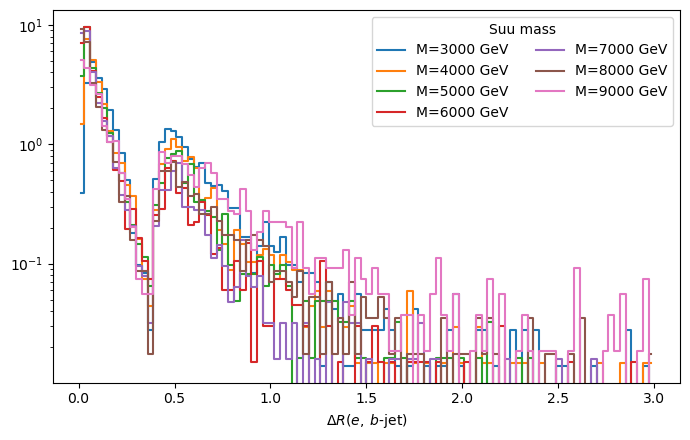

In [5]:
import numpy as np
import matplotlib.pyplot as plt

bins = np.linspace(0.0, 3.0, 101)
centers = 0.5*(bins[1:]+bins[:-1])
names  = ["Suu-tu_MC_M3000","Suu-tu_MC_M4000","Suu-tu_MC_M5000","Suu-tu_MC_M6000",
          "Suu-tu_MC_M7000","Suu-tu_MC_M8000","Suu-tu_MC_M9000"]
labels = ["M=3000 GeV","M=4000 GeV","M=5000 GeV","M=6000 GeV","M=7000 GeV","M=8000 GeV","M=9000 GeV"]

plt.figure(figsize=(7,4.5))
for name,label in zip(names,labels):
    counts,_ = np.histogram(reco_dR_all[name], bins=bins, density=True)
    plt.step(centers, counts, where="mid", label=label)

plt.yscale("log")
plt.xlabel(r"$\Delta R(e,\;b\text{-jet})$")
#plt.ylabel("# events")
plt.legend(title="Suu mass", ncol=2)
plt.tight_layout(); plt.show()


In [ ]:
'''
SuuToTU_TToBLNu_MSuu-9000
b jet match cut: 0.1
Total events: 2315
Events with ≥1 matched e: 2114
Events with ≥1 matched b: 1425
Events with ≥1 matched e AND ≥1 matched b: 1268

b jet match cut: 0.2
Total events: 2315
Events with ≥1 matched e: 2114
Events with ≥1 matched b: 1930
Events with ≥1 matched e AND ≥1 matched b: 1749

b jet match cut: 0.3
Total events: 2315
Events with ≥1 matched e: 2114
Events with ≥1 matched b: 2131
Events with ≥1 matched e AND ≥1 matched b: 1938

b jet match cut: 0.4
Total events: 2315
Events with ≥1 matched e: 2114
Events with ≥1 matched b: 2201
Events with ≥1 matched e AND ≥1 matched b: 2003

dr 0.2 (0.4/2)
print number of events...
cutflow for #events pass the non-isolated electron trigger (for electron might have issue)
trigger: https://twiki.cern.ch/twiki/bin/view/CMS/EgHLTRunIIISummary
'''